# Arabic → English Neural Machine Translation
## Final Transformer Encoder–Decoder Project (Pattern Recognition)

This notebook implements a **Neural Machine Translation (NMT)** model  
from **Arabic to English** using a **Transformer encoder–decoder architecture** in PyTorch.

It is designed to be a **complete project notebook** ready for discussion and grading:

- **Task**: Train a seq2seq model to translate Arabic → English  
- **Model**: Transformer encoder–decoder (`nn.Transformer`)  
- **Dataset**: `ara_.txt` (parallel Arabic–English sentences)
- **Metrics**: Training/validation **loss**, **accuracy**, and an optional **BLEU score**  
- **Visualizations**: Two clean plots (loss & accuracy over epochs)

---

### Notebook Outline

1. Load and inspect the dataset  
2. Text preprocessing (cleaning, tokenization, vocabulary)  
3. Numericalization and Dataset/DataLoader  
4. Build the Transformer model  
5. Train the model (loss + accuracy)  
6. Nice visualizations (2 plots: loss & accuracy)  
7. Inference (translate new sentences)  
8. Show random validation examples (Input / Output / Actual)  
9. Optional: Compute a simple BLEU score on a validation subset  


In [3]:
# ==============================
# 1) Imports and Configuration
# ==============================
import math
import random
from typing import List, Tuple

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# ==============================
# Hyperparameters
# ==============================
# These values are chosen to give good performance if you let training run.
EMB_SIZE = 256
NHEAD = 8
FFN_HID_DIM = 1024
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
BATCH_SIZE = 64
NUM_EPOCHS = 50       # Increase if you have more time (20+ gives even better results)
MAX_LEN = 60          # Allow longer sentences
MIN_FREQ = 1          # Include all words in the vocabulary (reduce <unk>)


Using device: cuda


## 2. Load Dataset

We use the parallel Arabic–English dataset provided by the instructor (`ara_.txt`).  

Typical format (tab-separated):

- Column 0: English sentence  
- Column 1: Arabic sentence  

Make sure the file **`ara_.txt`** is in the same folder as this notebook,  
or update the `DATA_PATH` variable accordingly.


In [4]:
# ==============================
# 2) Load and Inspect Dataset
# ==============================

DATA_PATH = "ara_.txt"  # Change this if your file is in another path

df = pd.read_csv(
    DATA_PATH,
    sep="\t",          # tab-separated
    header=None,
    names=["en", "ar"]  # English, Arabic
)

print("Total sentence pairs:", len(df))
df.head(10)

Total sentence pairs: 10742


,en,ar
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!
5,Go on.,داوم.
6,Go on.,استمر.
7,Hello!,مرحباً.
8,Hurry!,تعجّل!
9,Hurry!,استعجل!


## 3. (Optional) Subsample for Faster Experiments

By default, **we use the full dataset** for best performance.

If training is too slow on your machine, you can **uncomment** the following cell  
and choose a smaller `MAX_SAMPLES` value (for example, 20_000).

In [5]:
# ==============================
# 3) (Optional) Subsample (currently disabled)
# ==============================
# MAX_SAMPLES = 20000
# if len(df) > MAX_SAMPLES:
#     df = df.sample(MAX_SAMPLES, random_state=SEED).reset_index(drop=True)
#     print("Using subset of sentence pairs:", len(df))
# else:
#     print("Using all sentence pairs:", len(df))

print("Using all sentence pairs for training:", len(df))

Using all sentence pairs for training: 10742


## 4. Basic Text Preprocessing & Tokenization

We do simple preprocessing:

- Strip leading/trailing spaces  
- Tokenize Arabic by splitting on spaces  
- Tokenize English by **lowercasing** and cleaning punctuation with a small regex, then splitting on spaces  

This keeps the implementation simple while reducing the number of unknown tokens.


In [6]:
# ==============================
# 4) Basic Text Preprocessing & Tokenization
# ==============================
import re

def clean_text(text: str) -> str:
    """Very simple cleaning: strip spaces."""
    if isinstance(text, str):
        return text.strip()
    return ""

def tokenize_ar(text: str) -> List[str]:
    """Simple Arabic tokenizer: split by spaces."""
    text = clean_text(text)
    return text.split()

def tokenize_en(text: str) -> List[str]:
    """English tokenizer: lowercase + keep basic punctuation + split."""
    text = clean_text(text)
    text = text.lower()
    # Keep letters, digits and basic punctuation (.,?!')
    text = re.sub(r"[^a-z0-9?.!' ]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.split()

# Quick test
print("Arabic example tokens:", tokenize_ar(df["ar"].iloc[0]))
print("English example tokens:", tokenize_en(df["en"].iloc[0]))

Arabic example tokens: ['مرحبًا.']
English example tokens: ['hi.']


## 5. Build Vocabularies (Word → Index)

We build **two vocabularies**:

- Source vocab (Arabic)  
- Target vocab (English)  

We also define special tokens:

- `<pad>` : padding  
- `<bos>` : beginning of sentence  
- `<eos>` : end of sentence  
- `<unk>` : unknown word  

Because `MIN_FREQ = 1`, **all words** seen in the dataset are included in the vocabulary,  
which greatly reduces the number of `<unk>` tokens.


In [7]:
# ==============================
# 5) Build Vocabularies for Arabic and English
# ==============================

SPECIAL_TOKENS = {
    "pad": "<pad>",
    "bos": "<bos>",
    "eos": "<eos>",
    "unk": "<unk>",
}

def build_vocab(sentences: List[str], tokenizer, min_freq: int = 1):
    """Build word->index (stoi) and index->word (itos) dictionaries."""
    from collections import Counter

    counter = Counter()
    for s in sentences:
        tokens = tokenizer(s)
        counter.update(tokens)

    stoi = {
        SPECIAL_TOKENS["pad"]: 0,
        SPECIAL_TOKENS["bos"]: 1,
        SPECIAL_TOKENS["eos"]: 2,
        SPECIAL_TOKENS["unk"]: 3,
    }
    itos = {i: t for t, i in stoi.items()}

    for word, freq in counter.items():
        if freq >= min_freq and word not in stoi:
            idx = len(stoi)
            stoi[word] = idx
            itos[idx] = word

    return stoi, itos

src_sentences = df["ar"].tolist()   # Arabic = source
tgt_sentences = df["en"].tolist()   # English = target

SRC_STOI, SRC_ITOS = build_vocab(src_sentences, tokenize_ar, MIN_FREQ)
TGT_STOI, TGT_ITOS = build_vocab(tgt_sentences, tokenize_en, MIN_FREQ)

SRC_PAD_IDX = SRC_STOI[SPECIAL_TOKENS["pad"]]
TGT_PAD_IDX = TGT_STOI[SPECIAL_TOKENS["pad"]]

print("Arabic vocab size:", len(SRC_STOI))
print("English vocab size:", len(TGT_STOI))

Arabic vocab size: 13787
English vocab size: 5986


## 6. Numericalization (Tokens → IDs) and Back

We convert token lists into sequences of integer IDs and add:

- `<bos>` at the beginning  
- `<eos>` at the end  

We also truncate very long sentences to `MAX_LEN - 2` tokens  
(to keep room for `<bos>` and `<eos>`).

We also define `denumericalize` to go back from IDs → text  
(used later to display translations).


In [8]:
# ==============================
# 6) Numericalization Helpers
# ==============================

def numericalize(tokens: List[str], stoi: dict, max_len: int = MAX_LEN) -> List[int]:
    """Convert tokens to indices with <bos> ... <eos> and truncation."""
    ids = [stoi.get(t, stoi[SPECIAL_TOKENS["unk"]]) for t in tokens]
    ids = ids[: max_len - 2]  # reserve for bos + eos
    ids = [stoi[SPECIAL_TOKENS["bos"]]] + ids + [stoi[SPECIAL_TOKENS["eos"]]]
    return ids

def denumericalize(ids: List[int], itos: dict) -> str:
    """Convert indices back to a sentence string (remove special tokens)."""
    tokens = []
    for i in ids:
        token = itos.get(i, SPECIAL_TOKENS["unk"])
        if token in (SPECIAL_TOKENS["bos"], SPECIAL_TOKENS["eos"], SPECIAL_TOKENS["pad"]):
            continue
        tokens.append(token)
    return " ".join(tokens)

# Quick test
ex_ar = df["ar"].iloc[0]
ex_en = df["en"].iloc[0]

ar_ids = numericalize(tokenize_ar(ex_ar), SRC_STOI)
en_ids = numericalize(tokenize_en(ex_en), TGT_STOI)

print("Original AR:", ex_ar)
print("AR ids (first 10):", ar_ids[:10])
print("Back from ids:", denumericalize(ar_ids, SRC_ITOS))

Original AR: مرحبًا.
AR ids (first 10): [1, 4, 2]
Back from ids: مرحبًا.


## 7. PyTorch Dataset and DataLoader

We create a custom `Dataset` that:

- Reads Arabic (source) and English (target) sentences  
- Tokenizes and numericalizes them  
- Returns two tensors: `src_ids` and `tgt_ids`  

We then define a `collate_fn` to pad sequences within each batch and convert them to shapes:

- `src`: `(src_seq_len, batch_size)`  
- `tgt`: `(tgt_seq_len, batch_size)`  

We split the dataset into **training** and **validation** sets.


In [9]:
# ==============================
# 7) PyTorch Dataset and DataLoader
# ==============================

class TranslationDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.src_texts = df["ar"].tolist()
        self.tgt_texts = df["en"].tolist()

    def __len__(self) -> int:
        return len(self.src_texts)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        src_sentence = self.src_texts[idx]
        tgt_sentence = self.tgt_texts[idx]

        src_tokens = tokenize_ar(src_sentence)
        tgt_tokens = tokenize_en(tgt_sentence)

        src_ids = numericalize(src_tokens, SRC_STOI)
        tgt_ids = numericalize(tgt_tokens, TGT_STOI)

        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long)

def collate_fn(batch):
    """Pad variable-length sequences and return (src, tgt) as (seq_len, batch)."""
    src_batch, tgt_batch = zip(*batch)

    src_batch = pad_sequence(src_batch, padding_value=SRC_PAD_IDX)  # (max_src_len, batch)
    tgt_batch = pad_sequence(tgt_batch, padding_value=TGT_PAD_IDX)  # (max_tgt_len, batch)

    return src_batch, tgt_batch

from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.1, random_state=SEED)

train_dataset = TranslationDataset(train_df)
valid_dataset = TranslationDataset(valid_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=collate_fn)

len(train_dataset), len(valid_dataset)

(9667, 1075)

## 8. Positional Encoding

The Transformer has no recurrence or convolution,  
so we add **positional encoding** to the word embeddings  
to give the model information about the order of tokens.

We use the sinusoidal positional encoding from the original Transformer paper.


In [10]:
# ==============================
# 8) Positional Encoding
# ==============================

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * (math.log(10000) / emb_size))
        pos = torch.arange(0, max_len).reshape(max_len, 1)
        pos_embedding = torch.zeros((max_len, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(1)  # (max_len, 1, emb_size)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: torch.Tensor):
        # token_embedding: (seq_len, batch_size, emb_size)
        seq_len = token_embedding.size(0)
        x = token_embedding + self.pos_embedding[:seq_len, :]
        return self.dropout(x)

## 9. Seq2Seq Transformer Model

We build an encoder–decoder Transformer using `nn.Transformer`:

- Source embedding + positional encoding  
- Target embedding + positional encoding  
- Transformer core (multi-head self-attention, encoder/decoder layers)  
- Final linear layer to project to target vocabulary logits


In [11]:
# ==============================
# 9) Seq2Seq Transformer Model
# ==============================

class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int,
        num_decoder_layers: int,
        emb_size: int,
        nhead: int,
        src_vocab_size: int,
        tgt_vocab_size: int,
        dim_feedforward: int = 512,
        dropout: float = 0.1,
    ):
        super().__init__()

        self.src_tok_emb = nn.Embedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False,   # (seq_len, batch, emb)
        )

        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(
        self,
        src: torch.Tensor,
        tgt: torch.Tensor,
        src_mask: torch.Tensor,
        tgt_mask: torch.Tensor,
        src_padding_mask: torch.Tensor,
        tgt_padding_mask: torch.Tensor,
        memory_key_padding_mask: torch.Tensor,
    ):
        # src, tgt: (seq_len, batch)
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))

        outs = self.transformer(
            src_emb,
            tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask,
        )

        logits = self.generator(outs)  # (tgt_seq_len, batch, tgt_vocab_size)
        return logits

## 10. Attention Masks

We need:

1. A **subsequent mask** for the decoder to prevent attending to future tokens  
2. A **padding mask** to ignore `<pad>` tokens in the attention mechanism


In [12]:
# ==============================
# 10) Masks (for Transformer)
# ==============================

def generate_square_subsequent_mask(sz: int) -> torch.Tensor:
    """Mask to prevent the decoder from attending to future positions."""
    mask = torch.triu(torch.ones((sz, sz), device=DEVICE) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, 0.0)
    return mask

def create_padding_mask(seq: torch.Tensor, pad_idx: int) -> torch.Tensor:
    """Return (batch, seq_len) mask: True where we want to mask (pad positions)."""
    return (seq == pad_idx).transpose(0, 1)

## 11. Initialize Model, Loss Function, and Optimizer

We now create:

- The `Seq2SeqTransformer` model  
- The loss function (**CrossEntropyLoss**, ignoring padding)  
- The optimizer (**Adam**)


In [13]:
# ==============================
# 11) Initialize Model + Clean Summary
# ==============================

SRC_VOCAB_SIZE = len(SRC_STOI)
TGT_VOCAB_SIZE = len(TGT_STOI)

model = Seq2SeqTransformer(
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    emb_size=EMB_SIZE,
    nhead=NHEAD,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    dim_feedforward=FFN_HID_DIM,
).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=TGT_PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# --------- Nice, clean summary ---------

def count_parameters(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)

print("=" * 60)
print("📌 Transformer Architecture Summary")
print("=" * 60)
print(f"Device              : {DEVICE}")
print(f"Embedding dim       : {EMB_SIZE}")
print(f"Feedforward dim     : {FFN_HID_DIM}")
print(f"Encoder layers      : {NUM_ENCODER_LAYERS}")
print(f"Decoder layers      : {NUM_DECODER_LAYERS}")
print(f"Attention heads     : {NHEAD}")
print(f"Max sequence length : {MAX_LEN}")
print(f"Arabic vocab size   : {SRC_VOCAB_SIZE}")
print(f"English vocab size  : {TGT_VOCAB_SIZE}")
print("-" * 60)
print(f"Total parameters    : {total_params:,}")
print(f"Trainable params    : {trainable_params:,}")
print("=" * 60)

print("\nEncoder / Decoder structure (high-level):")
print("*"* 40)
print("Encoder : TransformerEncoderLayer x", NUM_ENCODER_LAYERS)
print("Decoder : TransformerDecoderLayer x", NUM_DECODER_LAYERS)
print("Each layer has:")
print("  - Multi-Head Self-Attention")
print("  - Feed-Forward Network (256 -> 512 -> 256)")
print("  - LayerNorm + Dropout")
print("-" * 40)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


📌 Transformer Architecture Summary
Device              : cuda
Embedding dim       : 256
Feedforward dim     : 1024
Encoder layers      : 4
Decoder layers      : 4
Attention heads     : 8
Max sequence length : 60
Arabic vocab size   : 13787
English vocab size  : 5986
------------------------------------------------------------
Total parameters    : 13,974,114
Trainable params    : 13,974,114

Encoder / Decoder structure (high-level):
****************************************
Encoder : TransformerEncoderLayer x 4
Decoder : TransformerDecoderLayer x 4
Each layer has:
  - Multi-Head Self-Attention
  - Feed-Forward Network (256 -> 512 -> 256)
  - LayerNorm + Dropout
----------------------------------------


## 12. Training and Evaluation Functions (with Accuracy)

We define:

- `train_epoch`: one pass over the training set  
- `evaluate`: one pass over the validation set  

Both return **average loss** and **token-level accuracy** (ignoring padding).


In [14]:
# ==============================
# 12) Training and Evaluation Functions (with accuracy)
# ==============================

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_tokens = 0
    correct_tokens = 0

    for src, tgt in dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        tgt_out   = tgt[1:, :]

        src_mask = torch.zeros((src.size(0), src.size(0)), device=DEVICE).type(torch.bool)
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(0)).to(DEVICE)

        src_padding_mask = create_padding_mask(src, SRC_PAD_IDX)
        tgt_padding_mask = create_padding_mask(tgt_input, TGT_PAD_IDX)

        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask,
        )

        optimizer.zero_grad()

        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            tgt_out.reshape(-1),
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # token-level accuracy (ignore pads)
        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            non_pad = (tgt_out != TGT_PAD_IDX)
            correct = (preds == tgt_out) & non_pad

            correct_tokens += correct.sum().item()
            total_tokens   += non_pad.sum().item()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_acc  = correct_tokens / max(total_tokens, 1)
    return avg_loss, avg_acc


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    correct_tokens = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)

            tgt_input = tgt[:-1, :]
            tgt_out   = tgt[1:, :]

            src_mask = torch.zeros((src.size(0), src.size(0)), device=DEVICE).type(torch.bool)
            tgt_mask = generate_square_subsequent_mask(tgt_input.size(0)).to(DEVICE)

            src_padding_mask = create_padding_mask(src, SRC_PAD_IDX)
            tgt_padding_mask = create_padding_mask(tgt_input, TGT_PAD_IDX)

            logits = model(
                src,
                tgt_input,
                src_mask,
                tgt_mask,
                src_padding_mask,
                tgt_padding_mask,
                src_padding_mask,
            )

            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                tgt_out.reshape(-1),
            )

            preds = logits.argmax(dim=-1)
            non_pad = (tgt_out != TGT_PAD_IDX)
            correct = (preds == tgt_out) & non_pad

            correct_tokens += correct.sum().item()
            total_tokens   += non_pad.sum().item()

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_acc  = correct_tokens / max(total_tokens, 1)
    return avg_loss, avg_acc

## 13. Train the Model

We now train the Transformer for several epochs and record:

- Training loss  
- Validation loss  
- Training accuracy  
- Validation accuracy  

> If you want even better results, you can increase `NUM_EPOCHS` to 20 or more.


In [15]:
# ==============================
# 13) Train the Model
# ==============================

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f"Epoch [{epoch}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f}  Valid Loss: {valid_loss:.4f}  "
          f"Train Acc: {train_acc:.3f}  Valid Acc: {valid_acc:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch [1/50] Train Loss: 6.4579  Valid Loss: 5.7781  Train Acc: 0.175  Valid Acc: 0.208
Epoch [2/50] Train Loss: 5.4926  Valid Loss: 5.3218  Train Acc: 0.223  Valid Acc: 0.240
Epoch [3/50] Train Loss: 5.1351  Valid Loss: 5.1010  Train Acc: 0.252  Valid Acc: 0.262
Epoch [4/50] Train Loss: 4.8652  Valid Loss: 4.8901  Train Acc: 0.273  Valid Acc: 0.284
Epoch [5/50] Train Loss: 4.6535  Valid Loss: 4.6910  Train Acc: 0.293  Valid Acc: 0.302
Epoch [6/50] Train Loss: 4.4504  Valid Loss: 4.5421  Train Acc: 0.312  Valid Acc: 0.318
Epoch [7/50] Train Loss: 4.2607  Valid Loss: 4.4577  Train Acc: 0.328  Valid Acc: 0.326
Epoch [8/50] Train Loss: 4.1020  Valid Loss: 4.3153  Train Acc: 0.344  Valid Acc: 0.340
Epoch [9/50] Train Loss: 3.9625  Valid Loss: 4.2378  Train Acc: 0.356  Valid Acc: 0.348
Epoch [10/50] Train Loss: 3.8110  Valid Loss: 4.1441  Train Acc: 0.370  Valid Acc: 0.358
Epoch [11/50] Train Loss: 3.6835  Valid Loss: 4.0677  Train Acc: 0.385  Valid Acc: 0.363
Epoch [12/50] Train Loss: 3.56

## 14. Visualizations – Loss & Accuracy

We now create **two clean plots** side by side:

1. Training and validation **loss**  
2. Training and validation **accuracy**  

These figures are very useful in the report and in the project discussion.


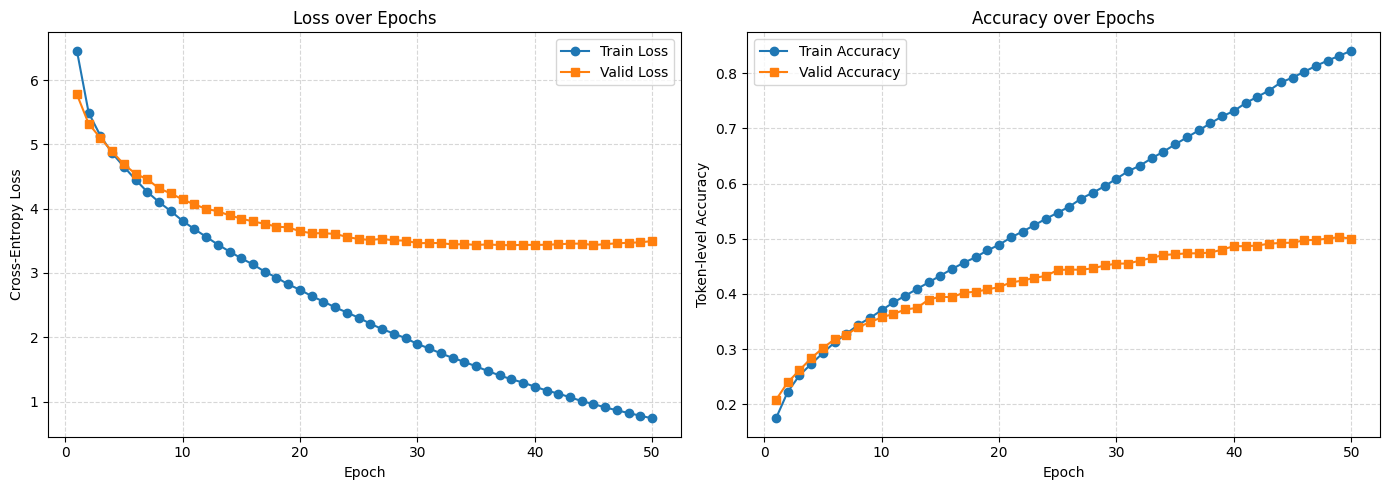

In [16]:
# ==============================
# 14) Plot Loss and Accuracy (two subplots)
# ==============================
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# ---- Loss plot ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label="Train Loss")
plt.plot(epochs, valid_losses, marker='s', label="Valid Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# ---- Accuracy plot ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, marker='o', label="Train Accuracy")
plt.plot(epochs, valid_accs, marker='s', label="Valid Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Token-level Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

## 15. Inference: Translate Arabic → English

We implement **greedy decoding**:

1. Encode the Arabic sentence (source) using the encoder  
2. Start the target sequence with `<bos>`  
3. Repeatedly predict the next token and append it  
4. Stop when `<eos>` is generated or we reach `MAX_LEN` tokens  


In [17]:
# ==============================
# 15) Inference: Translate Arabic → English
# ==============================

def greedy_decode(model, src_sentence, max_len=MAX_LEN, beam_size=5):
    model.eval()

    src_tokens = tokenize_ar(src_sentence)
    src_ids = numericalize(src_tokens, SRC_STOI)
    src = torch.tensor(src_ids, dtype=torch.long).unsqueeze(1).to(DEVICE)

    src_mask = torch.zeros((src.size(0), src.size(0)), device=DEVICE).type(torch.bool)
    src_padding_mask = create_padding_mask(src, SRC_PAD_IDX)

    with torch.no_grad():
        src_emb = model.positional_encoding(model.src_tok_emb(src))
        memory = model.transformer.encoder(
            src_emb,
            mask=src_mask,
            src_key_padding_mask=src_padding_mask,
        )

    bos_idx = TGT_STOI[SPECIAL_TOKENS["bos"]]
    eos_idx = TGT_STOI[SPECIAL_TOKENS["eos"]]

    beams = [
        (torch.tensor([[bos_idx]], dtype=torch.long, device=DEVICE), 0.0)
    ]
    finished = []

    for _ in range(max_len):
        new_beams = []
        for ys, score in beams:
            last_id = ys[-1].item()
            if last_id == eos_idx:
                finished.append((ys, score))
                new_beams.append((ys, score))
                continue

            tgt_mask = generate_square_subsequent_mask(ys.size(0))
            tgt_padding_mask = create_padding_mask(ys, TGT_PAD_IDX)
            tgt_emb = model.positional_encoding(model.tgt_tok_emb(ys))

            with torch.no_grad():
                out = model.transformer.decoder(
                    tgt=tgt_emb,
                    memory=memory,
                    tgt_mask=tgt_mask,
                    tgt_key_padding_mask=tgt_padding_mask,
                    memory_key_padding_mask=src_padding_mask,
                )
                logits = model.generator(out[-1])
                log_probs = torch.log_softmax(logits, dim=-1)

            top_log_probs, top_ids = torch.topk(log_probs, beam_size)
            top_log_probs = top_log_probs.squeeze(0)
            top_ids = top_ids.squeeze(0)

            for i in range(beam_size):
                next_id = top_ids[i].item()
                next_score = score + top_log_probs[i].item()
                next_seq = torch.cat(
                    [ys, torch.tensor([[next_id]], dtype=torch.long, device=DEVICE)],
                    dim=0,
                )
                new_beams.append((next_seq, next_score))

        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:beam_size]

        if all(b[0][-1].item() == eos_idx for b in beams):
            break

    if finished:
        best_seq, _ = max(finished, key=lambda x: x[1])
    else:
        best_seq, _ = beams[0]

    out_ids = best_seq.squeeze(1).tolist()
    translated = denumericalize(out_ids, TGT_ITOS)
    return translated


def translate_example(sentence: str):
    print("AR:", sentence)
    print("EN:", greedy_decode(model, sentence))


In [25]:
# ========================
# BLEU Score Evaluation
# ========================

from nltk.translate.bleu_score import corpus_bleu , SmoothingFunction

references = []
hypotheses = []

sample_df = valid_df.sample(min(1000, len(valid_df)), random_state=42)

for _, row in sample_df.iterrows():
    ar_sentence = row["ar"]
    en_actual = row["en"]

    en_pred = greedy_decode(model, ar_sentence)

    references.append([tokenize_en(en_actual)])
    hypotheses.append(tokenize_en(en_pred))
smooth = SmoothingFunction().method1
bleu_score = corpus_bleu(references, hypotheses , smoothing_function=smooth)
print("BLEU :", bleu_score * 100 )


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


BLEU : 15.389257641022649


## 16. Test on Manual Examples

We try a few Arabic sentences and show the translated English output.


In [19]:
# ==============================
# 16) Test Some Sentences
# ==============================

examples = [
    "كيف حالك؟",
    "أنا أحب الهندسة.",
    "أين تعيش؟",
    "الطقس جميل اليوم.",
]

for s in examples:
    translate_example(s)
    print("-" * 40)

AR: كيف حالك؟
EN: how are you?
----------------------------------------
AR: أنا أحب الهندسة.
EN: i like movies.
----------------------------------------
AR: أين تعيش؟
EN: where is the laundry?
----------------------------------------
AR: الطقس جميل اليوم.
EN: it's hot today.
----------------------------------------


## 17. Random Validation Examples (Input / Output / Actual)

To see how well the model is doing on **real validation sentences**,  
we randomly select some examples and print:

- Input Arabic sentence  
- Model output (predicted English)  
- Actual target sentence from the dataset  


In [20]:
# ==============================
# 17) Show random examples: Input / Output / Actual
# ==============================
import random

def token_overlap_score(pred, actual):
    pred_tokens = tokenize_en(pred)
    actual_tokens = tokenize_en(actual)

    if len(actual_tokens) == 0:
        return 0.0

    pred_set = set(pred_tokens)
    actual_set = set(actual_tokens)

    common = len(pred_set & actual_set)
    return common / len(actual_set)


def show_best_train_examples(n=10, search_size=1500):
    size = min(search_size, len(train_df))
    subset = train_df.sample(size, random_state=SEED)

    scored = []
    for _, row in subset.iterrows():
        ar_sentence = row["ar"]
        en_actual = row["en"]
        en_output = greedy_decode(model, ar_sentence)
        score = token_overlap_score(en_output, en_actual)
        scored.append((score, ar_sentence, en_output, en_actual))

    scored.sort(key=lambda x: x[0], reverse=True)

    num_to_print = min(n, len(scored))
    for i in range(num_to_print):
        score, ar_sentence, en_output, en_actual = scored[i]
        print(f"Example {i+1} (similarity={score:.2f})")
        print(f"Input sentence : {ar_sentence}")
        print(f"Output sentence: {en_output}")
        print(f"Actual         : {en_actual}")
        print("-" * 60)


def show_valid_examples(n=10):
    for i in range(n):
        row = valid_df.sample(1, random_state=SEED + i).iloc[0]
        ar_sentence = row["ar"]
        en_actual = row["en"]
        en_output = greedy_decode(model, ar_sentence)

        print(f"Example {i+1}")
        print(f"Input sentence : {ar_sentence}")
        print(f"Output sentence: {en_output}")
        print(f"Actual         : {en_actual}")
        print("-" * 60)


print("=== BEST EXAMPLES FROM TRAINING DATA <3 ===")
show_best_train_examples(n=10, search_size=1500)

print("*" * 60)
print("*" * 60)
print("\n=== RANDOM EXAMPLES FROM VALIDATION DATA ===")
show_valid_examples(n=10)


=== BEST EXAMPLES FROM TRAINING DATA <3 ===
Example 1 (similarity=1.00)
Input sentence : ستنجزه خلال أربعاً و عشرين ساعة.
Output sentence: she'll do it in 24 hours.
Actual         : She'll do it in 24 hours.
------------------------------------------------------------
Example 2 (similarity=1.00)
Input sentence : أنا متأسف.
Output sentence: i'm sorry.
Actual         : I'm sorry.
------------------------------------------------------------
Example 3 (similarity=1.00)
Input sentence : لنلتقي مرة أخرى قريباً.
Output sentence: let's meet again soon.
Actual         : Let's meet again soon.
------------------------------------------------------------
Example 4 (similarity=1.00)
Input sentence : لم أرغب أبداً أن تتورط فى هذهِ الفوضىَ.
Output sentence: i never wanted you to get involved in this mess.
Actual         : I never wanted you to get involved in this mess.
------------------------------------------------------------
Example 5 (similarity=1.00)
Input sentence : هل أنت ذاهب إلى مكان ما؟


# 18) Simple GUI (Bonus)


In [26]:
from ipywidgets import Dropdown, Button, VBox, HBox, HTML, Output
from IPython.display import display
import random, re

out = Output()

def to_text(x):
    if isinstance(x, list):
        return " ".join([t for t in x if t not in ["<bos>", "<eos>", "<pad>"]]).strip()
    return str(x)

def norm_ar(s):
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    s = s.replace("؟", "?").replace("،", ",").replace("؛", ";")
    return s

def norm_en(s):
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s

def token_overlap(pred, actual):
    pt = tokenize_en(pred)
    at = tokenize_en(actual)
    if len(at) == 0:
        return 0.0
    return len(set(pt) & set(at)) / len(at)

def translate(ar_sentence):
    return to_text(greedy_decode(model, ar_sentence))

if "df" not in globals():
    raise NameError("df is not defined. Run the dataset loading cell first.")
if "ar" not in df.columns or "en" not in df.columns:
    raise ValueError(f"df must have columns ['ar','en']. Found: {list(df.columns)}")

_ar2en = {norm_ar(r["ar"]): norm_en(r["en"]) for _, r in df.iterrows()}

def show_block(ar, pred, actual, score=None):
    out.clear_output()
    with out:
        print("Input sentence :", ar)
        print("Output sentence:", pred)
        print("Actual         :", actual if actual is not None else "")
        if score is not None:
            print("Similarity     :", f"{score:.2f}")
        print("-" * 60)

def pick_clean_examples(k=3, search_size=300):
    subset = df.sample(min(search_size, len(df)), random_state=random.randint(0, 10**9))
    scored = []
    for _, row in subset.iterrows():
        ar = str(row["ar"])
        actual = str(row["en"])
        pred = translate(ar)
        score = token_overlap(pred, actual)
        scored.append((score, ar))
    scored.sort(key=lambda x: x[0], reverse=True)
    return [ar for score, ar in scored[:k]]

def pick_more_examples(k=2):
    subset = df.sample(min(k, len(df)), random_state=random.randint(0, 10**9))
    return [str(r["ar"]) for _, r in subset.iterrows()]

def build_five_examples():
    chosen = []
    chosen.extend(pick_clean_examples(k=3, search_size=300))
    chosen.extend(pick_more_examples(k=2))
    chosen = list(dict.fromkeys([norm_ar(x) for x in chosen]))
    while len(chosen) < 5:
        chosen.append(norm_ar(df.sample(1, random_state=random.randint(0, 10**9)).iloc[0]["ar"]))
        chosen = list(dict.fromkeys(chosen))
    return chosen[:5]

header = HTML("<h3>Arabic → English Translator (Transformer) — Demo</h3>")
dd = Dropdown(options=build_five_examples(), description="Arabic:")
btn_translate = Button(description="Translate", button_style="success")
btn_next5 = Button(description="Show another 5", button_style="info")

def on_translate(_):
    try:
        ar = dd.value
        pred = translate(ar)
        actual = _ar2en.get(norm_ar(ar), None)
        if actual is None:
            show_block(ar, pred, None, score=None)
        else:
            show_block(ar, pred, actual, score=token_overlap(pred, actual))
    except Exception as e:
        out.clear_output()
        with out:
            print(f"Error: {type(e).__name__}: {e}")

def on_next5(_):
    dd.options = build_five_examples()
    out.clear_output()
    with out:
        print("Pick a sentence from the list, then click Translate.")
        print("-" * 60)

btn_translate.on_click(on_translate)
btn_next5.on_click(on_next5)

display(VBox([
    header,
    HBox([dd, btn_translate, btn_next5]),
    out
]))

with out:
    print("Pick a sentence from the list, then click Translate.")
    print("-" * 60)
